# Problem Session 8
## Classifying Pumpkin Seeds I

In the next few notebooks you will work to build models to classify types of pumpkin seeds using features engineered from photographs of the seeds. Here we will introduce the data set, perform some exploratory data analysis and build some simple models.

The problems in this notebook will cover the content covered in our `Classification` notebooks including:
- `Adjustments for Classification`,
- `k Nearest Neighbors`,
- `The Confusion Matrix` and
- `Logistic Regression`.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

#### 1. Load the data

##### a.

First load the data stored in `Pumpkin_Seeds_Dataset.xlsx` in the `data` folder.

Note you will want to use the `read_excel` function from `pandas`, <a href="https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html?highlight=read_excel">https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html?highlight=read_excel</a>. Print a random sample of five rows.

##### Sample Solution

In [32]:
seeds = pd.read_excel("../../data/Pumpkin_Seeds_Dataset.xlsx")

In [33]:
seeds.sample(5)

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class
1011,74330,1062.751,408.6018,233.3467,75260,307.6360,0.8209,0.9876,0.7283,0.8270,1.7511,0.7529,Çerçevelik
2435,60291,1020.062,402.4420,193.8990,61478,277.0648,0.8763,0.9807,0.7556,0.7281,2.0755,0.6885,Ürgüp Sivrisi
1168,87065,1162.496,452.8571,245.7026,88043,332.9483,0.8400,0.9889,0.7393,0.8096,1.8431,0.7352,Çerçevelik
619,68076,984.754,356.6101,244.7813,69002,294.4097,0.7272,0.9866,0.7391,0.8822,1.4569,0.8256,Çerçevelik
1355,55462,952.253,383.5621,185.4874,56210,265.7375,0.8753,0.9867,0.7201,0.7686,2.0679,0.6928,Ürgüp Sivrisi


##### b.

Create a new column of the `DataFrame` called `y` where `y=1` if `Class=Ürgüp Sivrisi` and `y=0` if `Class=Çerçevelik`.

##### Sample Solution

In [34]:
seeds['y'] = 0

seeds.loc[seeds.Class=='Ürgüp Sivrisi', 'y']=1

#### 2. Learn about the data

##### a.

These data represent various measurements of pumpkin seeds that come from high quality photos of the seeds. The data was provided as supplementary material to <a href="https://link.springer.com/article/10.1007/s10722-021-01226-0">The use of machine learning methods in classification of pumpkin seeds (Cucurbita pepo L.)</a> by Koklu, Sarigil and Ozbek (2021).

In this work the researchers demonstrated how various algorithms could be used to predict whether a pumpkin seed was a Ürgüp Sivrisi seed or a Çerçevelik seed. These data were generated by engineering features from special photos of seeds like so:
<br>
<br>
<img src="problem_session_8_assets/pumpkin_seeds.jpg" width="55%"></img>

As you can see these two seeds can be quite difficult for the human eye to discern, hence the appeal to machine learning algorithms.

A PDF of this paper is provided here, <a href="problem_session_8_assets/pumpkin_seed_paper.pdf">pumpkin_seed_paper.pdf</a>. Scroll down to Figure 5 and Table 1 and read about the features of this data set.

#### 3. Train test split

##### a.

Look at how the data is split between the two classes. Does this appear to be imbalanced data? <i>Recall that we say data is imbalanced if one of the classes has a very small presence in the data set.

##### Sample Solution

In [35]:
seeds.Class.value_counts(normalize=True)

Class
Çerçevelik       0.52
Ürgüp Sivrisi    0.48
Name: proportion, dtype: float64

This data set seems pretty well balanced.

##### b.

Make a train test split, set aside $10\%$ of the data as the test set (note that we are using $10\%$ because this was the split they used in the paper).

##### Sample Solution

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
seeds_train, seeds_test = train_test_split(seeds.copy(),
                                              shuffle=True,
                                              random_state=123,
                                              test_size=.1,
                                              stratify=seeds.y.values)

#### 4. Exploratory data analysis (EDA)

Before building any models you will do some EDA.

##### a. 

One way to try and identify key features for classification algorithms is to plot histograms of the feature values for each of the classes.

Below is an example of such a histogram for the `Area` column made using `plt.hist`.

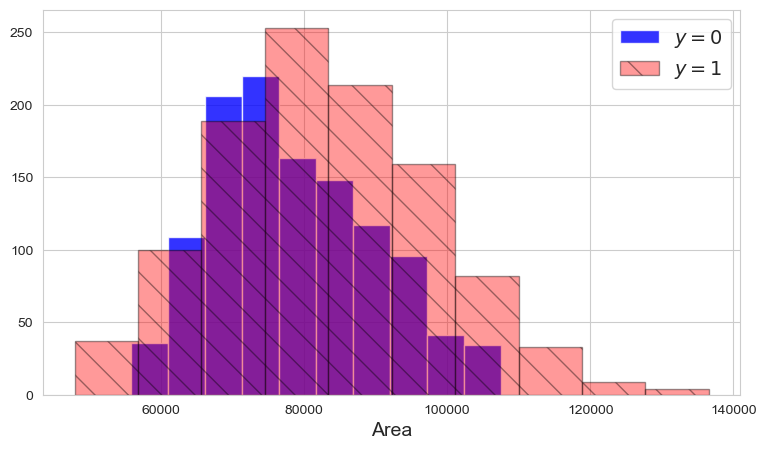

In [38]:
plt.figure(figsize=(9,5))


plt.hist(seeds_train.loc[seeds_train.y==0].Area.values,
            color='blue',
            alpha=.8,
            label="$y=0$")

plt.hist(seeds_train.loc[seeds_train.y==1].Area.values,
            color='red',
            alpha=.4,
            hatch = '\\',
            edgecolor='black',
            label="$y=1$")

plt.xlabel("Area", fontsize=14)
plt.legend(fontsize=14)

plt.show()

In this plot we can see that the two histograms are right on top of one another, indicating that the two classes of pumpkin seeds tend to have similar areas. This suggests that `Area` may not be a useful variable for discerning the seed class.

Use a `for` loop or some comparable method to produce similar histograms for each of the features. Write down the features that look like they may be useful for classification.

##### Sample Solution

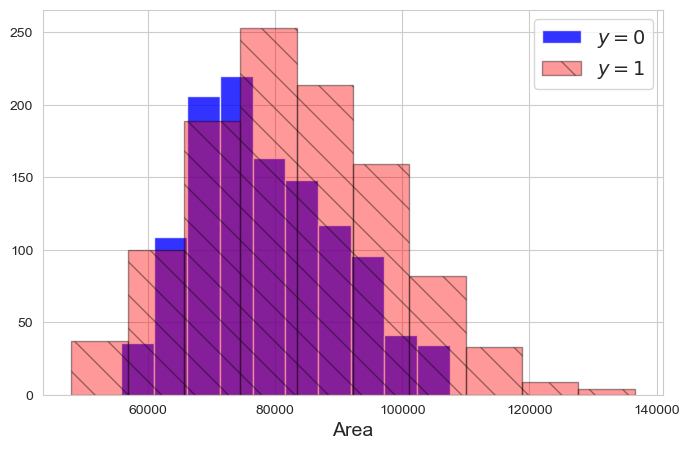

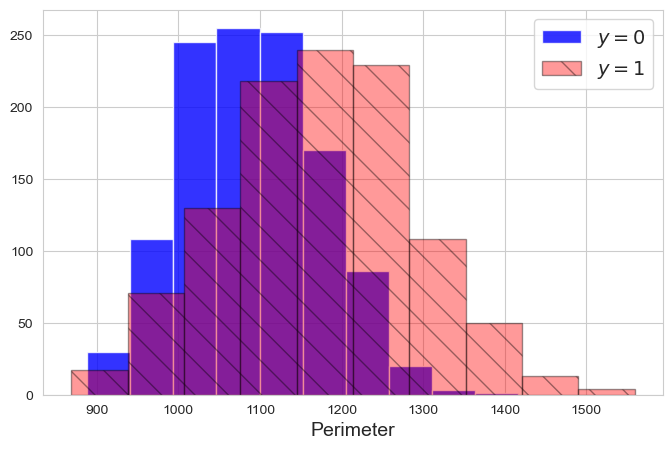

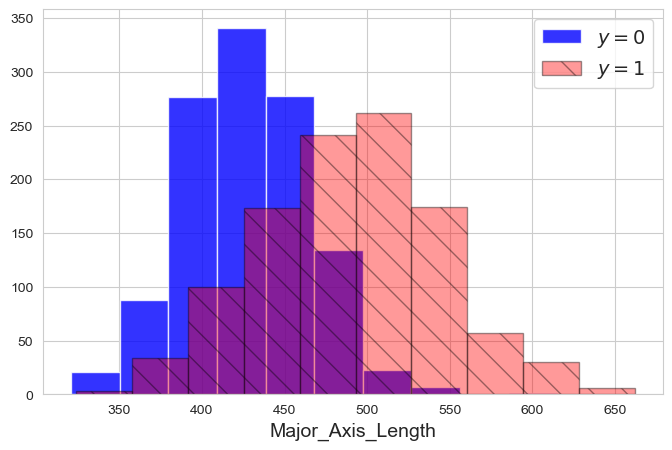

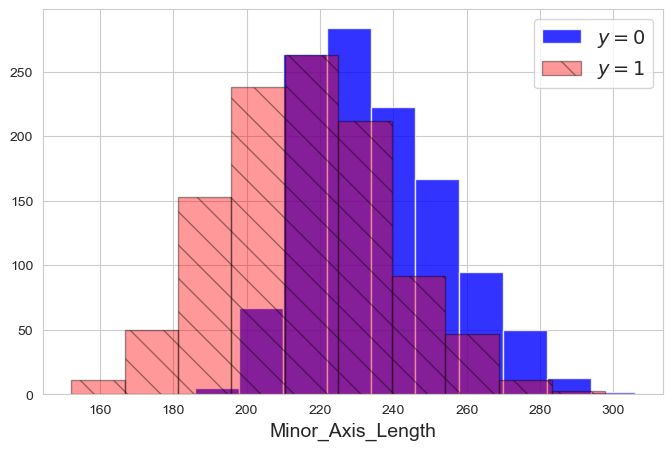

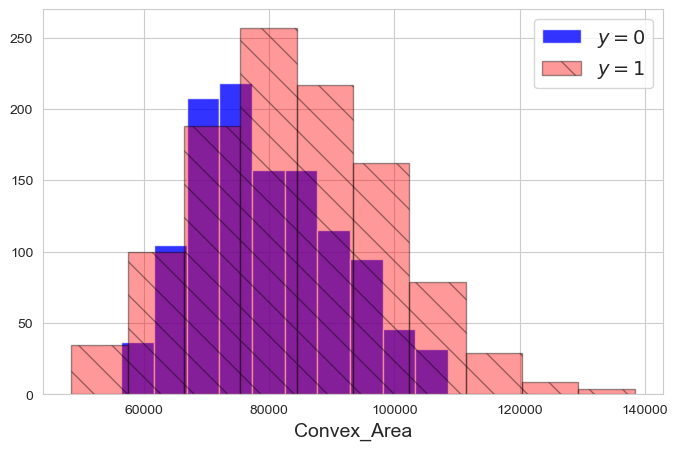

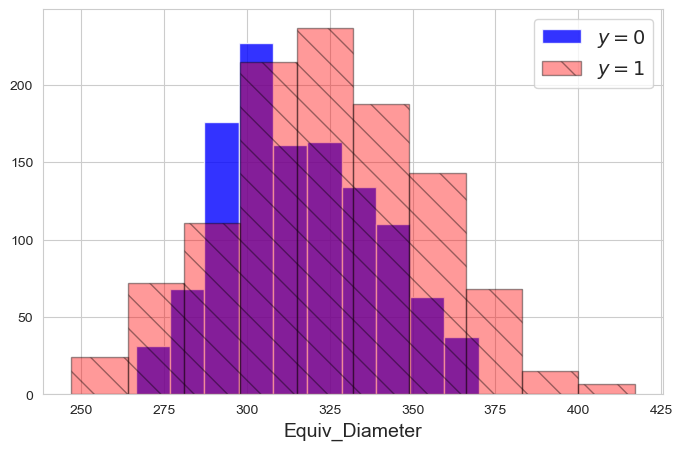

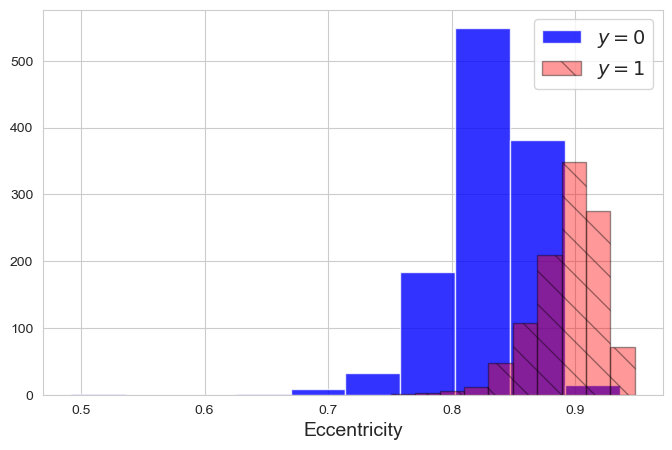

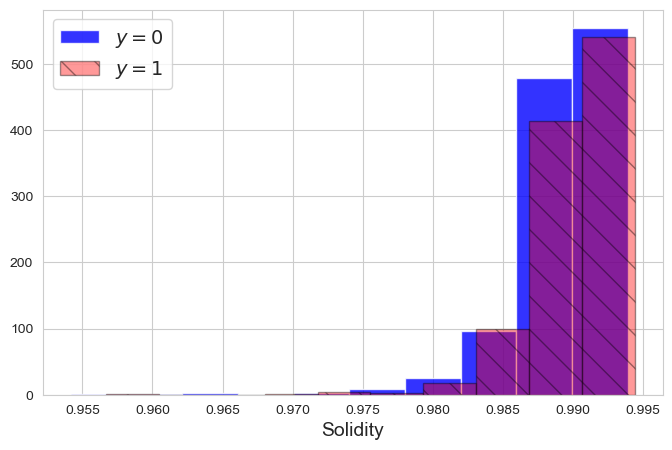

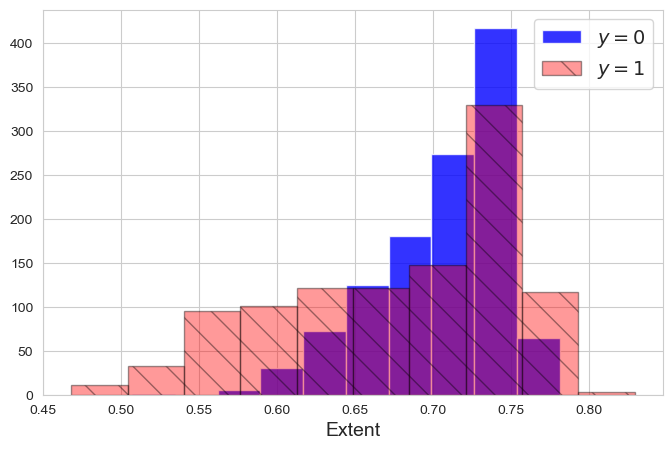

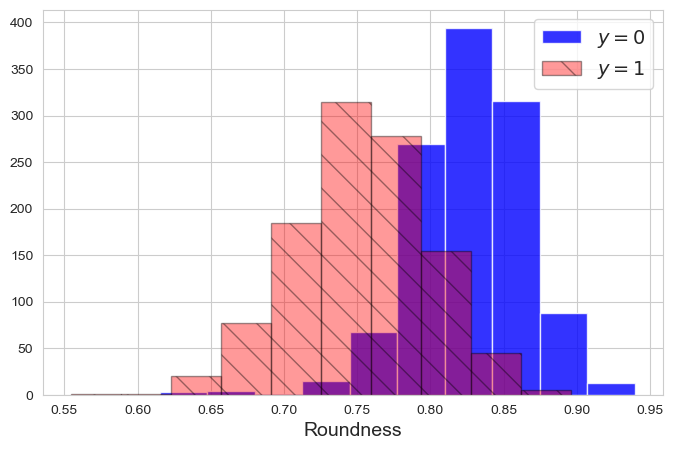

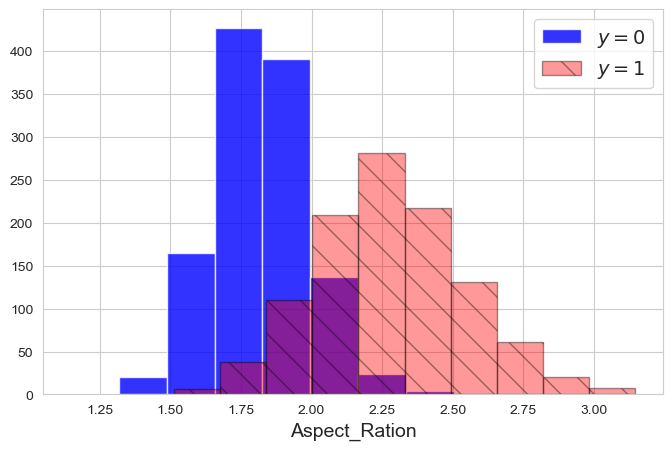

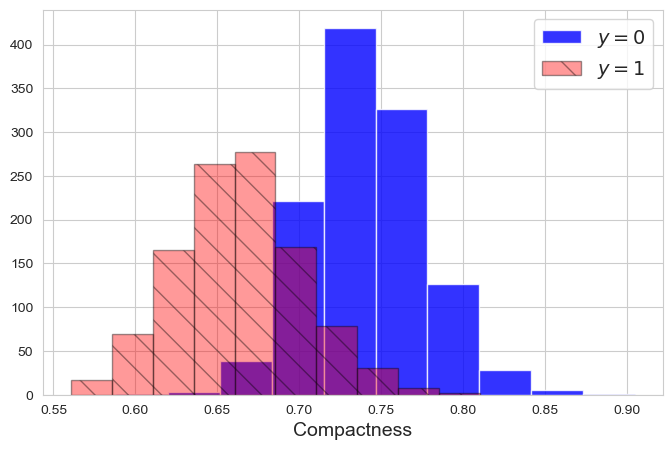

In [39]:
for col in seeds_train.columns[:-2]:
    plt.figure(figsize=(8,5))


    plt.hist(seeds_train.loc[seeds_train.y==0, col].values,
                color='blue',
                alpha=.8,
                label="$y=0$")

    plt.hist(seeds_train.loc[seeds_train.y==1, col].values,
                color='red',
                alpha=.4,
                hatch = '\\',
                edgecolor='black',
                label="$y=1$")

    plt.xlabel(col, fontsize=14)
    plt.legend(fontsize=14)

    plt.show()

These features seem like they may be useful in classifying the seeds.
- `Major_Axis_Length`
- `Eccentricity`
- `Roundness`
- `Aspect_Ration`
- `Compactness`

##### b.

Now try making a `seaborn` `pairplot` using the variables you identified in part <i>a.</i> as the arguments for `x_vars` and `y_vars`. Use `y` as the argument to `hue`. The main goal with this question is to see if you can identify any pairs of variables that seem to separate the two classes. You will use these plots later in the notebook.

##### Sample Solution

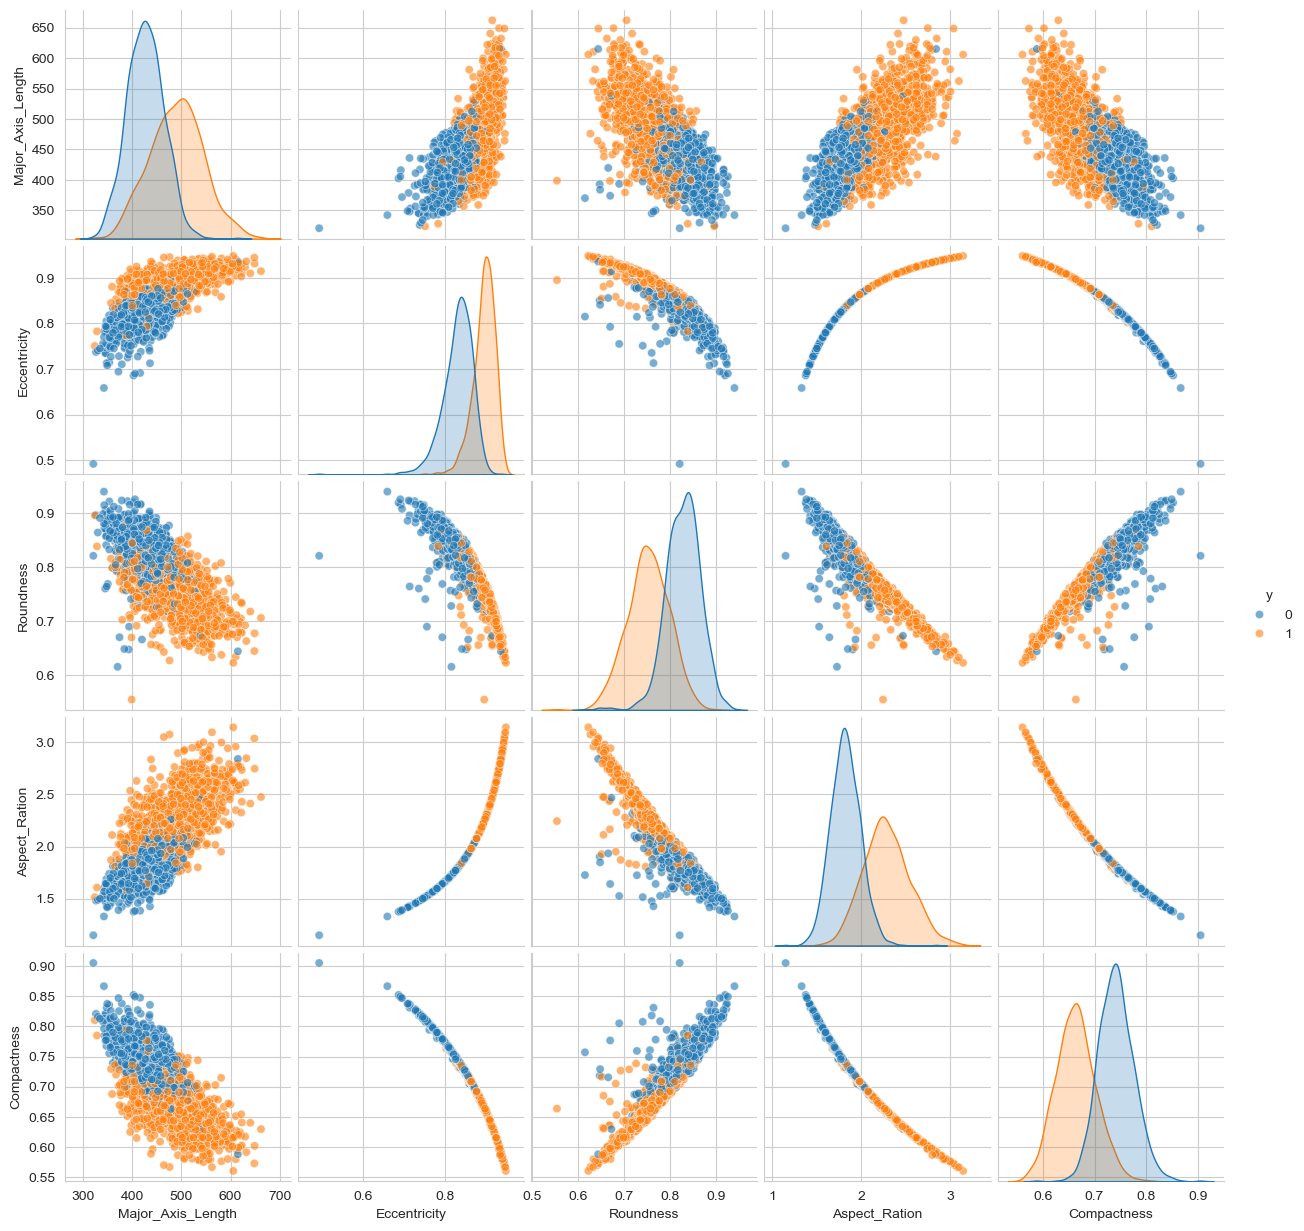

In [40]:
sns.pairplot(data = seeds_train,
                x_vars = ['Major_Axis_Length', 'Eccentricity', 
                              'Roundness', 'Aspect_Ration', 'Compactness'],
                y_vars = ['Major_Axis_Length', 'Eccentricity', 
                              'Roundness', 'Aspect_Ration', 'Compactness'],
                hue = 'y',
                plot_kws = {'alpha':.6})

plt.show()

Note that it appears that there is an exact functional relationship between `Aspect_Ration`, `Compactness`, and `Eccentricity`.  We should include at most one of these features in our model.

I am going to select the features `Major_Axis_Length`, `Compactness`, and `Roundness`.

#### 5. Metric selection

In the remainder of this notebook you will make some initial models.

##### a.

Now that you have read about the data and looked at the split between the two classes what seems like a reasonable performance metric for this problem? Explain your answer.

##### Sample Solution

For this problem accuracy is probably a good metric. The classes are well balanced so we will not get an artificially high accuracy and without knowing of any major differences between the two types of pumpkin seeds there is no reason to focus on the proper classification of one of the classes over the other.

##### b.

Recalling that `y=1` implies that the seed is of the Ürgüp Sivrisi class and `y=0` implies that the seed is of the Çerçevelik class, what do the following metrics measure in the context of this classification problem:
- recall
- precision
- false positive rate.

##### Sample Solution

- recall measures what fraction of observations that are actually a $1$ are predicted to be a $1$. In this context that would mean the fraction of seeds we correctly identify to be of the Ürgüp Sivrisi class.
- precision measures what fraction of the predicted $1$s are actually $1$s. In this context that means the fraction of predicted Ürgüp Sivrisi seeds are actually Ürgüp Sivrisi seeds.
- fpr measures the fraction of actual $0$s that are incorrectly predicted to be $1$s. In this setting that means the fraction of Çerçevelik seeds that are classified as Ürgüp Sivrisi seeds.


#### 6. Initial modeling attempts

In the remainder of this notebook you will make some initial models.

##### a.

Think of a baseline model for these data. Some common approaches are:
- A random coin flip whose probability for heads is the same as the probability of drawing the more present class,
- Classifying any observation as the majority class.

For whichever baseline you choose project the generalization accuracy of the baseline using the training data.

##### Sample Solution

##### Random coin flip

In [41]:
from sklearn.metrics import accuracy_score

In [42]:
random_accs = []

for i in range(1000):
    draw = np.random.binomial(n=1,
                                 p=seeds_train.y.sum()/len(seeds_train),
                                 size=len(seeds_train))
    
    random_accs.append(accuracy_score(seeds_train.y.values, draw))

In [43]:
np.mean(random_accs)

np.float64(0.5010760000000001)

Should be about $50\%$.

##### Majority Class

In [44]:
seeds_train.y.value_counts(normalize=True)

y
0    0.52
1    0.48
Name: proportion, dtype: float64

About $52\%$.

##### b.

Fill in the code below to perform 5-fold cross-validation in order to compare logistic regression models regressing `y` on each of the useful features you identified in your EDA above.

For this notebook run Logistic Regression without any L2 regularization.  Note that if we *did* regularize we should scale our regressors first, just like with linear regression.

##### Sample Solution

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [46]:
n_splits = 5

kfold = StratifiedKFold(n_splits,
                           shuffle=True,
                           random_state=498)

In [47]:
features = ['Major_Axis_Length', 'Compactness', 'Roundness']

log_reg_accs = np.zeros((n_splits, len(features)))

i = 0
for train_index, test_index in kfold.split(seeds_train, seeds_train.y):
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    j = 0
    for feature in features:
        log_reg = LogisticRegression(penalty=None)
        
        log_reg.fit(seeds_tt[feature].values.reshape(-1,1),
                       seeds_tt.y.values)
        
        pred = log_reg.predict(seeds_ho[feature].values.reshape(-1,1))
        
        log_reg_accs[i,j] = accuracy_score(seeds_ho.y.values,
                                              pred)
        
        j = j + 1
    i = i + 1

In [48]:
np.mean(log_reg_accs, axis = 0)

array([0.76177778, 0.86311111, 0.82622222])

Of these three features, "Compactness" is the best.

##### c.

Compare these models to the logistic regression model that incorporates all of the features you identified with your histogram exploration.

##### Sample Solution

In [49]:
full_log_accs = np.zeros(n_splits)

i = 0
for train_index, test_index in kfold.split(seeds_train, seeds_train.y):
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    log_reg = LogisticRegression(penalty=None,
                                     max_iter = 1000)
        
    log_reg.fit(seeds_tt[features].values,
                   seeds_tt.y.values)
        
    pred = log_reg.predict(seeds_ho[features].values)
    
    full_log_accs[i] = accuracy_score(seeds_ho.y.values,
                                              pred)
    
    i = i + 1

In [50]:
np.mean(full_log_accs)

np.float64(0.8711111111111112)

We do get better accuracy using all of the features! 

We could perform the same feature selection approaches that we discussed in the linear regression material to find the best logistic regression model.

##### d.

Fill in the code to find the optimal $k$ for a $k$ nearest neighbors model encorporating all of the features.

##### Sample Solution

In [51]:
## Import the model classes.  Remember that we should always scale our features before using kNN.  So you should build pipelines to do this for you.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [52]:
ks = range(1, 56)
all_features = seeds_train.columns[:-2]

k_all_accs = np.zeros((n_splits, len(ks)))

i = 0
for train_index, test_index in kfold.split(seeds_train, seeds_train.y):
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    j = 0
    for k in ks:
        knn = Pipeline([('scale', StandardScaler()),('knn_cls', KNeighborsClassifier(k))])
        
        knn.fit(seeds_tt[all_features].values,
                   seeds_tt.y.values)
        
        pred = knn.predict(seeds_ho[all_features].values)
        
        k_all_accs[i,j] = accuracy_score(seeds_ho.y.values, pred)
        
        j = j + 1
    i = i + 1

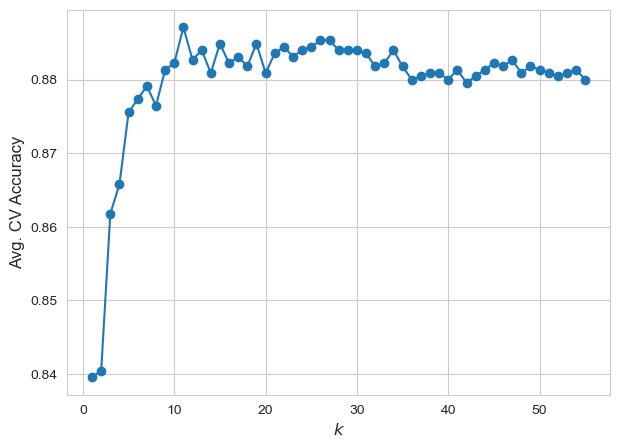

In [53]:
plt.figure(figsize=(7,5))


plt.plot(ks, 
         np.mean(k_all_accs, axis=0),
         '-o')


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)

plt.show()

In [54]:
best_k = np.argmax(np.mean(k_all_accs, axis=0))
best_k_acc = np.mean(k_all_accs, axis=0)[best_k]

print("The optimal value of k was", best_k + 1, "which achieved a mean CV accuracy of ", best_k_acc)

The optimal value of k was 11 which achieved a mean CV accuracy of  0.8871111111111112


##### e. 

Now see if you can improve the accuracy by using just the features you chose as a result of your histogram explorations. Did the best accuracy change? Did the optimal value of $k$ change?

##### Sample Solution

In [55]:
ks = range(1, 56)

k_select_accs = np.zeros((n_splits, len(ks)))

i = 0
for train_index, test_index in kfold.split(seeds_train, seeds_train.y):
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    j = 0
    for k in ks:
        knn = Pipeline([('scale', StandardScaler()),('knn_cls', KNeighborsClassifier(k))])
        
        knn.fit(seeds_tt[features].values,
                   seeds_tt.y.values)
        
        pred = knn.predict(seeds_ho[features].values)
        
        k_select_accs[i,j] = accuracy_score(seeds_ho.y.values, pred)
        
        j = j + 1
    i = i + 1

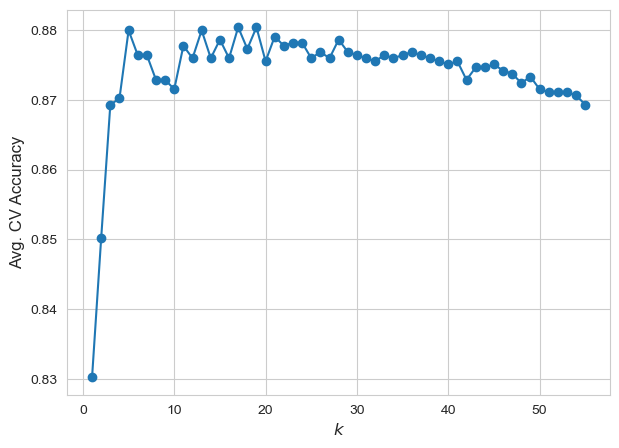

In [56]:
plt.figure(figsize=(7,5))


plt.plot(ks, 
         np.mean(k_select_accs, axis=0),
         '-o')


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)

plt.show()

In [57]:
best_k = np.argmax(np.mean(k_select_accs, axis=0))
best_k_acc = np.mean(k_select_accs, axis=0)[best_k]

print("The optimal value of k was", best_k + 1, "which achieved a mean CV accuracy of ", best_k_acc)

The optimal value of k was 17 which achieved a mean CV accuracy of  0.8804444444444446


The mean CV accuract of kNN was essentially the same using all features or using our hand selected features.

##### f.

As a final check see if you can improve the cross-validation accuracy further by only considering a pair of features from your `pairplot` exploration earlier.

##### Sample Solution

In [58]:
ks = range(1, 56)

k_final_accs = np.zeros((n_splits, len(ks)))

i = 0
for train_index, test_index in kfold.split(seeds_train, seeds_train.y):
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    j = 0
    for k in ks:
        knn = Pipeline([('scale', StandardScaler()),('knn_cls', KNeighborsClassifier(k))])
        
        knn.fit(seeds_tt[['Compactness', 'Major_Axis_Length']].values,
                   seeds_tt.y.values)
        
        pred = knn.predict(seeds_ho[['Compactness', 'Major_Axis_Length']].values)
        
        k_final_accs[i,j] = accuracy_score(seeds_ho.y.values, pred)
        
        j = j + 1
    i = i + 1

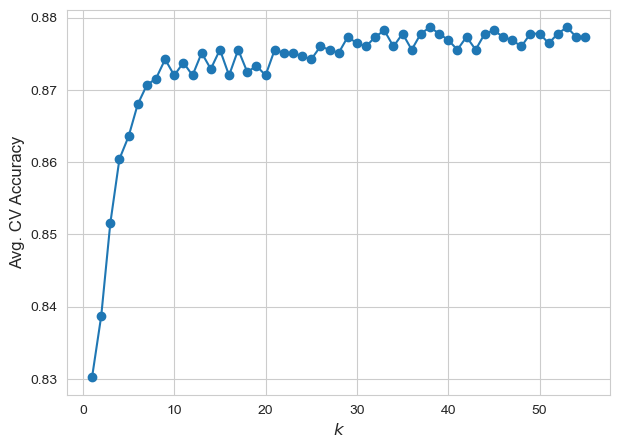

In [59]:
plt.figure(figsize=(7,5))


plt.plot(ks, 
         np.mean(k_final_accs, axis=0),
         '-o')


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)

plt.show()

In [60]:
best_k = np.argmax(np.mean(k_final_accs, axis=0))
best_k_acc = np.mean(k_final_accs, axis=0)[best_k]

print("The optimal value of k was", best_k + 1, "which achieved a mean CV accuracy of ", best_k_acc)

The optimal value of k was 38 which achieved a mean CV accuracy of  0.8786666666666665


##### 7. Summarizing the current results

Consider the best average CV accuracies of all of the models you built. Which one performed the best?

##### Sample Solution

- $k$-NN with just the two features had about $87.8\%$ avg. cv. accuracy with $38$ neighbors,
- $k$-NN with the hand selected features had about $87.8\%$ avg. cv. accuracy with $42$ neighbors,
- $k$-NN with all features had a little over $88.6\%$ avg. cv. accuracy with $11$ neighbor,
- Log. Reg. with 3 hand selected feature topped out at around $82.9\%$ avg. cv. accuracy
- Log. Reg. with all of the selected features got around $86.7%$ avg. cv. accuracy.

It seems that $k$-NN with all features has the best cross validation accuracy. 

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)